In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
dPath = Path("../docs/dumps")

In [3]:
with open(dPath / "test_set_data.pkl", 'rb') as filename:
    test_data = pickle.load(filename)

In [4]:
with open(dPath / "rf_exp_05_names.pkl", 'rb') as filename:
    names = pickle.load(filename)

In [5]:
X_test = []
y_test = []

In [6]:
for i in range(len(test_data)):
    test_data[i] = test_data[i][test_data[i].numExecuted > 0]
    X_test.append(test_data[i].drop("Detected", axis=1))
    y_test.append(test_data[i].Detected)
    X_test[i] = test_data[i][names]

In [7]:
with open(dPath / "mutclslabels.pkl", 'rb') as filename:
    mutclslabels = pickle.load(filename)

In [8]:
with open(dPath / "retypelabels.pkl", 'rb') as filename:
    retypelabels = pickle.load(filename)

In [9]:
mutclscodes = dict(zip(mutclslabels,range(len(mutclslabels))))

In [10]:
retypecodes = dict(zip(retypelabels,range(len(retypelabels))))

In [11]:
for i in range(len(test_data)):
    X_test[i].replace(mutclscodes, inplace=True)
    X_test[i].replace(retypecodes, inplace=True)

In [12]:
with open(dPath / "hgb_exp_02_stacking.pkl", 'rb') as filename:
    hgbs = pickle.load(filename)

In [13]:
rm_indices = []
for i in range(len(X_test)):
    if X_test[i].shape[0] <= 10:
        rm_indices.append(i)

In [14]:
X_test = [i for j, i in enumerate(X_test) if j not in rm_indices]

In [15]:
y_test = [i for j, i in enumerate(y_test) if j not in rm_indices]

In [16]:
hgbs_preds = []
for i in range(len(X_test)):
    predictions = []
    for _model in hgbs:
        predictions.append(_model.predict_proba(X_test[i])[:,1])
    hgbs_preds_test = np.vstack(predictions).T
    hgbs_preds.append(hgbs_preds_test.mean(axis=1))

In [19]:
balanced_accuracy_scores = []
matthews_corrcoef_scores = []
average_precision_scores = []
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
log_losses = []
zero_one_loss = []
for i in range(len(hgbs_preds)):  
    try:
        balanced_accuracy_scores.append(metrics.balanced_accuracy_score(y_test[i], (hgbs_preds[i]) >= 0.5, adjusted=True))
        matthews_corrcoef_scores.append(metrics.matthews_corrcoef(y_test[i], (hgbs_preds[i])>= 0.5))
        average_precision_scores.append(metrics.average_precision_score(y_test[i], (hgbs_preds[i]) >=0.5))
        roc_auc_scores.append(metrics.roc_auc_score(y_test[i], (hgbs_preds[i]) >=0.5))
        precision_scores.append(metrics.precision_score(y_test[i], (hgbs_preds[i]) >= 0.5))
        recall_scores.append(metrics.recall_score(y_test[i], (hgbs_preds[i])>= 0.5))
        f1_scores.append(metrics.f1_score(y_test[i], (hgbs_preds[i]) >= 0.5))
        log_losses.append(metrics.log_loss(y_test[i], (hgbs_preds[i]) >= 0.5))
        zero_one_loss.append(metrics.zero_one_loss(y_test[i], (hgbs_preds[i]) >= 0.5))
    except:
        pass

In [20]:
import matplotlib.pyplot as plt

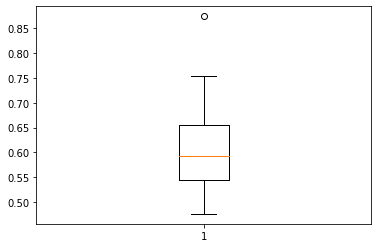

In [21]:
plt.boxplot(np.array(roc_auc_scores));

In [22]:
np.average(roc_auc_scores)

0.603305835236064

In [23]:
np.median(roc_auc_scores)

0.5926978114478115

In [24]:
df = pd.DataFrame([balanced_accuracy_scores,matthews_corrcoef_scores,average_precision_scores,roc_auc_scores,precision_scores,recall_scores,f1_scores,log_losses,zero_one_loss]).T

In [25]:
df.columns = ['balanced_accuracy_scores','matthews_corrcoef_scores','average_precision_scores','roc_auc_scores','precision_scores','recall_scores','f1_scores','log_losses','zero_one_loss']

In [26]:
df.to_excel(dPath / "hgbs_evaluation.xlsx")